<a href="https://colab.research.google.com/github/JimKing100/DS-Unit-2-Regression-Classification/blob/master/Notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import and Load Data

In [0]:
%%capture
!pip install -r requirements.txt

In [118]:
import os, sys

os.chdir('/content')
!git init .
!git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
!git pull origin master
os.chdir('module1')

Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
# Get Pandas Profiling Report
#df.profile_report()

### Simple Linear Regression

In [121]:
# Read New York City apartment rental listing data
import pandas as pd
import pandas_profiling
import seaborn as sns
import statistics 
import plotly.express as px

# Read the rental data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Use the subset with a price over $1,000 and below $10,000, eliminate outliers
mask = (df['price'] > 1000) & (df['price'] < 10000)
df = df[mask]

# longitudes should be in -74 range, eliminate outliers
df.query('longitude < -75 or longitude > -73')

# Clean up bedrooms, eliminate outliers
mask = (df['bedrooms'] < 6)
df = df[mask]

# Clean up bathrooms, eliminate outliers
mask = (df['bathrooms'] < 5)
df = df[mask]

# 1. Import the appropriate estimator class from Scikit-Learn
from sklearn.linear_model import LinearRegression

# 2. Instantiate this class
model = LinearRegression()

# 3. Arrange X features matrix & y target vector
features = ['bedrooms']
target = 'price'
X = df[features]
y = df[target]

# 4. Fit the model
model.fit(X, y)

# 5. Apply the model
def predict(bedrooms):
    y_pred = model.predict([[bedrooms]])
    return y_pred[0]

# Predict a 3 bedroom and check against the mean 3 bedroom.
print('Prediction for 3 Bedroom Rent: ', predict(3))
print('Mean of 3 Bedroom Rent: ', statistics.mean(df['price']))

Prediction for 3 Bedroom Rent:  4501.414209362802
Mean of 3 Bedroom Rent:  3433.9535105149857


### Multiple Regression

In [0]:
# Imports
%matplotlib inline

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import plotly.express as px

import seaborn as sns

In [0]:
# Read New York City apartment rental listing data
df = pd.read_csv('../data/renthop-nyc.csv')
assert df.shape == (49352, 34)

# Remove the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= np.percentile(df['price'], 0.5)) & 
        (df['price'] <= np.percentile(df['price'], 99.5)) & 
        (df['latitude'] >= np.percentile(df['latitude'], 0.05)) & 
        (df['latitude'] < np.percentile(df['latitude'], 99.95)) &
        (df['longitude'] >= np.percentile(df['longitude'], 0.05)) & 
        (df['longitude'] <= np.percentile(df['longitude'], 99.95))]

#### Test/Train Split on Date

In [124]:
# Convert to datetime and look at the date range
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)

# There are 16217 + 15627 observations in April & May 2016,
# and 16973 observations in June 2016.
df['created'].dt.month.value_counts()

# Date split
cutoff = pd.to_datetime('2016-06-01')
train = df[df.created < cutoff]
test = df[df.created >= cutoff]
train.shape, test.shape

((31844, 34), (16973, 34))

In [0]:
# Look at relationship between location & price
#px.scatter(train, x = 'longitude', y = 'latitude', color = 'price')

#### Clustering Using KMeans

In [126]:
# Cluster the locations
kmeans = KMeans(n_clusters=10, n_jobs = -1)
train['cluster'] = kmeans.fit_predict(train[['longitude', 'latitude']])
test['cluster'] = kmeans.predict(test[['longitude', 'latitude']])
#px.scatter(train, x='longitude', y ='latitude', color = 'cluster')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



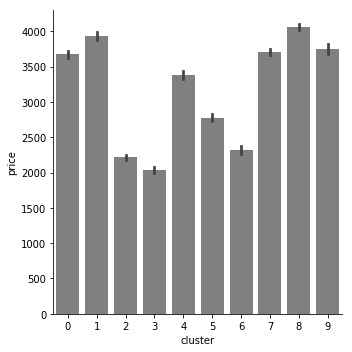

In [127]:
sns.catplot(x='cluster', y='price', data=train, kind = 'bar', color='grey')

#### Graph All Columns/Features

In [0]:
# Graph each column against target
#for col in sorted(train.columns):
#    if train[col].nunique() < 12:
#        sns.catplot(x=col, y='price', data = train, kind = 'bar', color = 'grey')
#        plt.show()

In [0]:
# Graph all numeric features
#numeric = train.select_dtypes('number')
#for col in sorted(numeric.columns):
#    sns.lmplot(x=col, y = 'price', data = train, scatter_kws = dict(alpha=0.05))
#    plt.show()

#### Engineer New Features

In [130]:
def engineer_features(df):
    #What's the neighborhood, based on address or latitude and longitude?
    clusters = pd.get_dummies(df['cluster'], prefix = 'cluster')
    for col in clusters:
        df[col] = clusters[col]

    #Does the apartment have a description?
    df['description'] = df['description'].str.strip().fillna('')
    df['has_description'] = df['description'] != ''

    #How long is the description?
    df['description_length'] = df['description'].str.len()

    #Are cats or dogs allowed?
    df['cats_or_dogs'] = (df['cats_allowed']==1) | (df['dogs_allowed']==1)

    #Are cats AND dogs allowed?
    df['cats_and_dogs'] = (df['cats_allowed']==1) & (df['dogs_allowed']==1)

    #Total number of rooms
    df['rooms'] = df['bedrooms'] + df['bathrooms']

    return df

train = engineer_features(train)
test = engineer_features(test)
train.shape, test.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-ve

((31844, 50), (16973, 50))

#### Quick Test With Just Numeric Coulmns/Features No Nulls

In [131]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'price'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((31844, 41), (31844,), (16973, 41), (16973,))

#### Select the 10 Features That Best Correlate to Target Using SelectKBest

In [132]:
#Select the 10 features that best correlate to the target
from sklearn.feature_selection import f_regression, SelectKBest

#This is similar to the way we did linear regression last time
#model = LinearRegression()
#model.fit(...)
selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

Features selected:
bathrooms
bedrooms
longitude
elevator
doorman
dishwasher
fitness_center
laundry_in_unit
dining_room
rooms


#### Run Multiple Linear Regression with MAE, R^2, R^2 Adj.

In [133]:
model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test MAE: ${mae:,.0f}')

import statsmodels.api as sm
X1 = sm.add_constant(X_train_selected)
result = sm.OLS(y_train, X1).fit()
print('R^2 = ', result.rsquared)
print('R^2 Adj. = ', result.rsquared_adj)

Test MAE: $712
R^2 =  0.6032124054152115
R^2 Adj. =  0.6031002269785946


#### Run Again - Iterate and Add Features

In [134]:
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)

  mae = mean_absolute_error(y_test, y_pred)
  print(f'Test MAE: ${mae:,.0f} ]\n')

1 features
Test MAE: $890 ]

2 features
Test MAE: $826 ]

3 features
Test MAE: $826 ]

4 features
Test MAE: $820 ]

5 features
Test MAE: $772 ]

6 features
Test MAE: $713 ]

7 features
Test MAE: $713 ]

8 features
Test MAE: $713 ]

9 features
Test MAE: $713 ]

10 features
Test MAE: $712 ]

11 features
Test MAE: $700 ]

12 features
Test MAE: $700 ]

13 features
Test MAE: $700 ]

14 features
Test MAE: $681 ]

15 features
Test MAE: $681 ]

16 features
Test MAE: $680 ]

17 features
Test MAE: $680 ]

18 features
Test MAE: $680 ]

19 features
Test MAE: $678 ]

20 features
Test MAE: $678 ]

21 features
Test MAE: $671 ]

22 features
Test MAE: $665 ]

23 features
Test MAE: $662 ]

24 features
Test MAE: $662 ]

25 features
Test MAE: $660 ]

26 features
Test MAE: $660 ]

27 features
Test MAE: $661 ]

28 features
Test MAE: $660 ]

29 features
Test MAE: $659 ]

30 features
Test MAE: $658 ]

31 features
Test MAE: $658 ]

32 features
Test MAE: $659 ]

33 features
Test MAE: $654 ]

34 features
Test MA